<a href="https://colab.research.google.com/github/hafsaaaaaaaa/MLPROJECT_/blob/main/AGE_AND_GENDER_DETECTION1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:09<00:00, 36.9MB/s]
100% 331M/331M [00:09<00:00, 35.0MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
path = "/content/crop_part1"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 9780
28_0_0_20170105162616443.jpg.chip.jpg


In [7]:
import cv2
import os

images = []
ages = []
genders = []

for file in files:
    try:
        image = cv2.imread(os.path.join(path, file), 0)
        if image is not None:
            image = cv2.resize(image, dsize=(64,64))
            image = image.reshape((image.shape[0], image.shape[1], 1))
            images.append(image)
            split_var = file.split('_')
            ages.append(split_var[0])
            genders.append(int(split_var[1]))
        else:
            print(f"Could not read image file: {file}")
    except Exception as e:
        print(f"Error reading image file {file}: {e}")


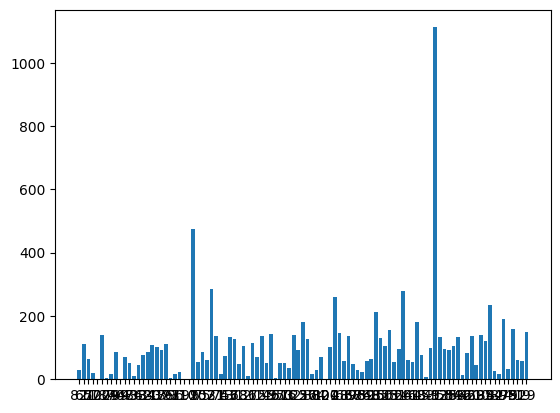

Max value: 99


In [8]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 50


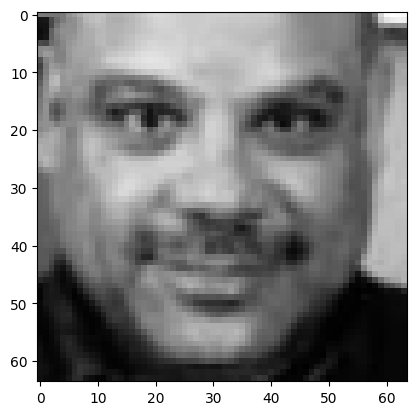

In [10]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 60
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [11]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

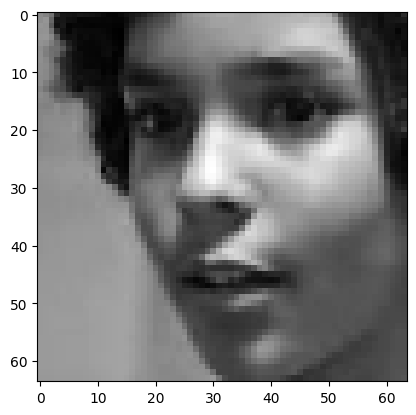

In [12]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 7824
Samples in Testing: 1956


In [14]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [15]:
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K

In [16]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [17]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 60, 60, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [19]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 100, batch_size=128,shuffle = True)

Epoch 1/100
62/62 [==============================] - 20s 59ms/step - loss: 0.9416 - dense_3_loss: 0.2479 - dense_9_loss: 0.6937 - dense_3_accuracy: 0.0102 - dense_9_accuracy: 0.5364 - val_loss: 0.8233 - val_dense_3_loss: 0.1350 - val_dense_9_loss: 0.6883 - val_dense_3_accuracy: 0.0000e+00 - val_dense_9_accuracy: 0.5567
Epoch 2/100
62/62 [==============================] - 3s 52ms/step - loss: 0.7812 - dense_3_loss: 0.0937 - dense_9_loss: 0.6875 - dense_3_accuracy: 0.0165 - dense_9_accuracy: 0.5433 - val_loss: 0.7281 - val_dense_3_loss: 0.0478 - val_dense_9_loss: 0.6803 - val_dense_3_accuracy: 0.0169 - val_dense_9_accuracy: 0.5567
Epoch 3/100
62/62 [==============================] - 3s 52ms/step - loss: 0.7442 - dense_3_loss: 0.0671 - dense_9_loss: 0.6771 - dense_3_accuracy: 0.0230 - dense_9_accuracy: 0.5431 - val_loss: 0.7138 - val_dense_3_loss: 0.0438 - val_dense_9_loss: 0.6700 - val_dense_3_accuracy: 0.0220 - val_dense_9_accuracy: 0.5567
Epoch 4/100
62/62 [============================

In [20]:
model.save('data.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


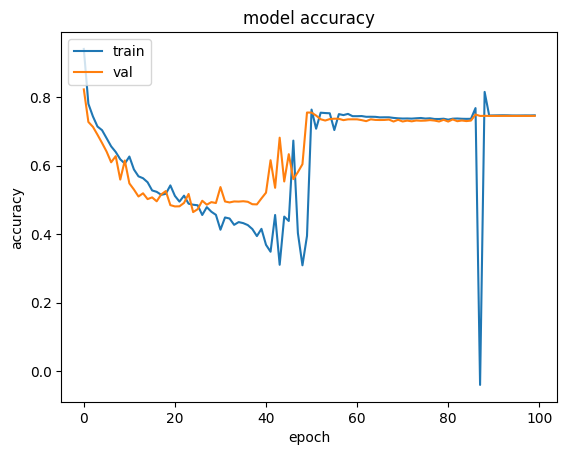

In [21]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

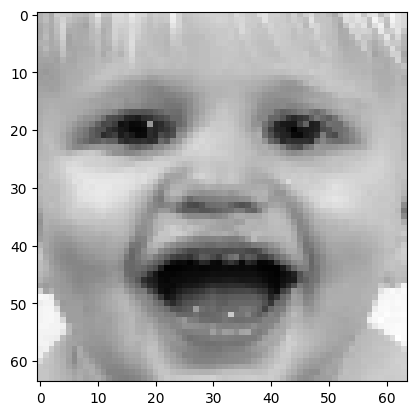

Actual Gender: Male Age: 2
1/1 [==============================] - 0s 224ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


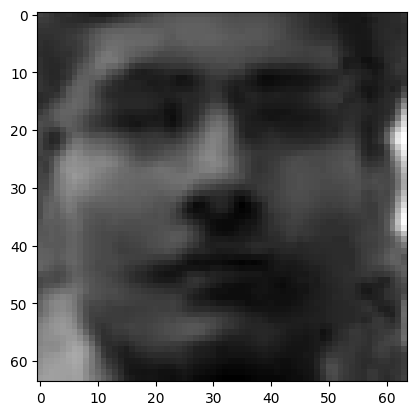

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 18ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


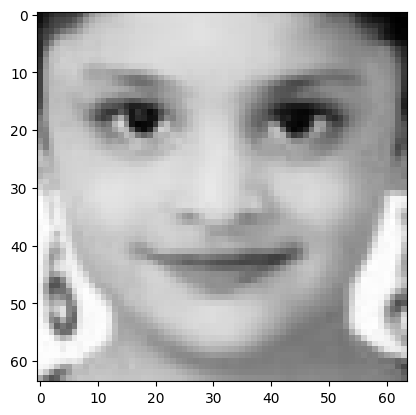

Actual Gender: Female Age: 10
1/1 [==============================] - 0s 18ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


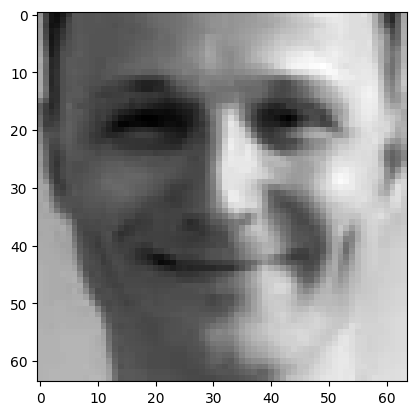

Actual Gender: Male Age: 37
1/1 [==============================] - 0s 16ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


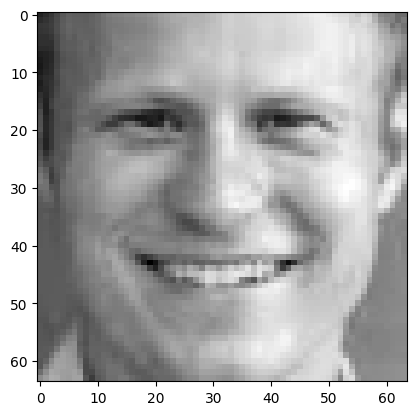

Actual Gender: Male Age: 31
1/1 [==============================] - 0s 17ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


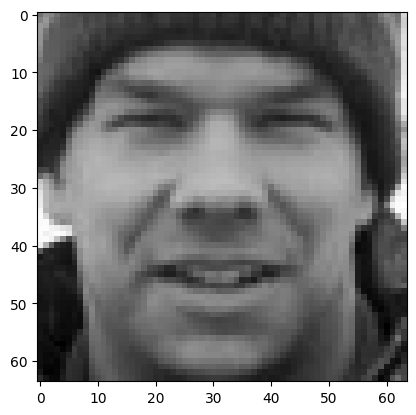

Actual Gender: Male Age: 34
1/1 [==============================] - 0s 17ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


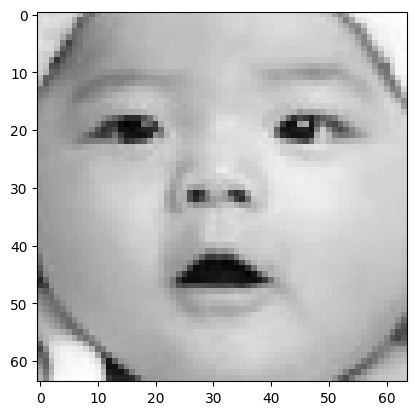

Actual Gender: Male Age: 1
1/1 [==============================] - 0s 17ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


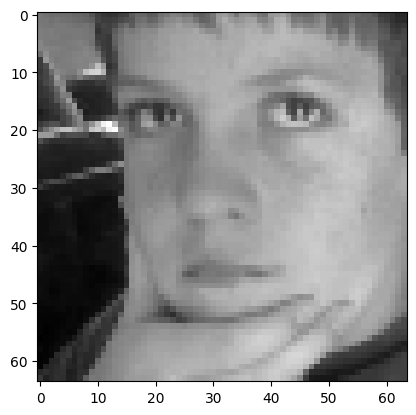

Actual Gender: Male Age: 16
1/1 [==============================] - 0s 17ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


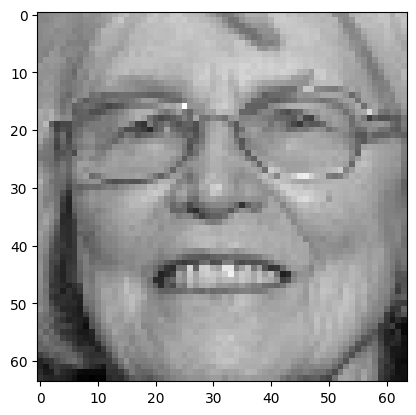

Actual Gender: Female Age: 72
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.5169642]], dtype=float32), array([[0.5459412]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


In [22]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)


indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)